# Recomender System

In [337]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [314]:
df = pd.read_csv('ml-20m/ratings.csv').iloc[:500000,:]
df.head()

len(df)

500000

In [315]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [316]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [317]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 15

In [318]:
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=512):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)
    

    # set the weights since N(0, 1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
  
  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)

    # merge
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.dropout(out,0.25)
    out = F.relu(out)
    out = self.fc2(out)
    
    
    return out

In [319]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Model(N, M, D)
model.to(device)

cpu


Model(
  (u_emb): Embedding(3374, 15)
  (m_emb): Embedding(12277, 15)
  (fc1): Linear(in_features=30, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [320]:
# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [321]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
 
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    # we could do this if the test set size was manageable
    # test_outputs = model(test_users, test_movies)
    # test_loss = criterion(test_outputs, test_ratings).item()
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()
      test_loss.append(loss)
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}')
  
  return train_losses, test_losses

In [322]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [323]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    epochs=25)

Epoch 1/25, Train Loss: 1.0783, Test Loss: 0.9215
Epoch 2/25, Train Loss: 0.8284, Test Loss: 0.7943
Epoch 3/25, Train Loss: 0.7699, Test Loss: 0.7757
Epoch 4/25, Train Loss: 0.7510, Test Loss: 0.7673
Epoch 5/25, Train Loss: 0.7378, Test Loss: 0.7586
Epoch 6/25, Train Loss: 0.7257, Test Loss: 0.7519
Epoch 7/25, Train Loss: 0.7147, Test Loss: 0.7461
Epoch 8/25, Train Loss: 0.7061, Test Loss: 0.7424
Epoch 9/25, Train Loss: 0.7000, Test Loss: 0.7392
Epoch 10/25, Train Loss: 0.6955, Test Loss: 0.7368
Epoch 11/25, Train Loss: 0.6913, Test Loss: 0.7382
Epoch 12/25, Train Loss: 0.6870, Test Loss: 0.7344
Epoch 13/25, Train Loss: 0.6836, Test Loss: 0.7361
Epoch 14/25, Train Loss: 0.6804, Test Loss: 0.7363
Epoch 15/25, Train Loss: 0.6771, Test Loss: 0.7337
Epoch 16/25, Train Loss: 0.6747, Test Loss: 0.7335
Epoch 17/25, Train Loss: 0.6726, Test Loss: 0.7299
Epoch 18/25, Train Loss: 0.6690, Test Loss: 0.7299
Epoch 19/25, Train Loss: 0.6666, Test Loss: 0.7309
Epoch 20/25, Train Loss: 0.6637, Test Lo

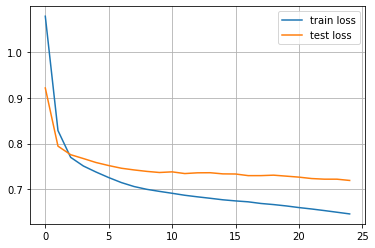

In [324]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.grid()
plt.show()

In [349]:
watched_movie_ids = df[df.new_user_id == 10].new_movie_id.values

In [350]:
watched_movie_ids

array([    0,     9,    18,    31,    38,    64,   107,   138,   143,
         146,   151,   153,   158,   163,   165,   166,   178,   201,
         223,   245,   248,   252,   278,   288,   308,   310,   335,
         347,   355,   358,   368,   371,   375,   391,   396,   427,
         428,   466,   486,   505,   513,   516,   526,   531,   536,
         566,   567,   568,   569,   572,   573,   575,   577,   586,
         588,   589,   594,   605,   618,   623,   638,   640,   698,
         701,   720,   737,   741,   779,   809,   826,   913,   969,
         970,   973,   977,   987,  1004,  1012,  1015,  1031,  1035,
        1069,  1096,  1097,  1122,  1123,  1124,  1126,  1135,  1138,
        1139,  1140,  1150,  1163,  1176,  1178,  1193,  1197,  1214,
        1242,  1243,  1260,  1287,  1305,  1309,  1346,  1423,  1435,
        1462,  1466,  1473,  1529,  1551,  1563,  1565,  1586,  1606,
        1688,  1700,  1706,  1739,  1783,  1799,  1804,  1826,  1833,
        1834,  1840,

In [360]:
commom_movies =  df[df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [353]:
len(set(potential_movie_ids))

potential_movie_ids

array([    1,    28,    46, ..., 12228, 12262, 12263], dtype=int16)

In [354]:
user_id_to_recommend = np.ones_like(potential_movie_ids)*10

len(user_id_to_recommend)

11773

In [355]:
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get predictions
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [356]:
# Convert predictions to Numpy
predictions_np = predictions.cpu().numpy().flatten()

# Get sort index for predictions
sort_idx = np.argsort(-predictions_np)

In [357]:
predictions_np

array([1.6766009, 1.6732798, 1.9299831, ..., 1.7275338, 1.6960481,
       1.4387869], dtype=float32)

In [358]:
sort_idx

array([1583, 3270, 2491, ..., 4781, 9282, 6433], dtype=int64)

In [359]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

 

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print("movie:", movie, "score:", score)

movie: 10648 score: 2.4482117
movie: 6947 score: 2.3977718
movie: 3037 score: 2.3647542
movie: 2423 score: 2.333911
movie: 11141 score: 2.3294787
movie: 2976 score: 2.3138437
movie: 8362 score: 2.3094692
movie: 7843 score: 2.2904353
movie: 11064 score: 2.2882392
movie: 7981 score: 2.2836423


In [335]:
movies = pd.read_csv('ml-20m/movies.csv')
movies.movieId = pd.Categorical(movies.movieId)
movies['new_movie_id'] = movies.movieId.cat.codes
movies.head()

,movieId,title,genres,new_movie_id
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [348]:
movies[movies['new_movie_id'].isin(top_10_movie_ids)]

,movieId,title,genres,new_movie_id
2344,2429,Mighty Joe Young (1998),Action|Adventure|Drama|Fantasy|Thriller,2344
2423,2508,"Breaks, The (1999)",Comedy,2423
2726,2812,In Too Deep (1999),Action|Thriller,2726
5176,5273,Very Annie Mary (2001),Comedy|Musical,5176
6260,6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX,6260
6713,6823,Under Suspicion (1992),Crime|Drama|Thriller,6713
6876,6988,Broken Blossoms or The Yellow Man and the Girl...,Drama|Romance,6876
7709,8228,"Maltese Falcon, The (a.k.a. Dangerous Female) ...",Mystery,7709
10563,40291,Siblings (2004),Comedy,10563
10989,45081,Silent Hill (2006),Fantasy|Horror|Thriller,10989


In [361]:
movies[movies['new_movie_id'].isin(commom_movies)]

,movieId,title,genres,new_movie_id
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0
9,10,GoldenEye (1995),Action|Adventure|Thriller,9
18,19,Ace Ventura: When Nature Calls (1995),Comedy,18
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,31
38,39,Clueless (1995),Comedy|Romance,38
...,...,...,...,...
10171,33801,Godzilla: Final Wars (Gojira: Fainaru uôzu) (2...,Action|Adventure|Fantasy|Sci-Fi,10171
10178,33826,Saint Ralph (2004),Comedy|Drama,10178
10246,34185,Staying Together (1989),Comedy|Drama,10246
10351,35957,Red Eye (2005),Horror|Thriller,10351
